In [1]:
from kan import *
import pickle
import numpy.linalg as LA
import matplotlib as mpl

In [2]:
with open('twobody_variables_data_3D.pkl', 'rb') as f:
    dp,dt,nx,m,predict_time,e = pickle.load(f)

data_x = torch.load('X_Data.pt')
train_x = data_x[0:40,:,:]
train_x = train_x.reshape([int(len(train_x)*(dp)),nx])
test_x = data_x[4:5,:,:]
test_x = test_x.reshape([int(len(test_x)*(dp)),nx])
data_y = torch.load('Y_Data.pt')
train_y = data_y[0:40,:,:]
train_y = train_y.reshape([int(len(train_y)*(dp)),nx])
test_y = data_y[4:5,:,:]
test_y = test_y.reshape([int(len(test_y)*(dp)),nx])
data_y2 = np.load('Y2_Data.pt')
train_y2 = data_y2[0:40,:,:]
train_y2 = train_y2.reshape([int(len(train_y2)*(dp)),nx])
test_y2 = data_y2[4:5,:,:]
test_y2 = test_y2.reshape([int(len(test_y2)*(dp)),nx])

dataset = {}
dataset['train_input'] = train_x
dataset['test_input'] = test_x
dataset['train_label'] = train_y
dataset['test_label'] = test_y

# ***Koopman Training***

In [3]:
lifted_space = 1
hidden_size = 1
learning_rate = 0.0001
Loss_prev = 1e38
P = np.cat((torch.eye(nx),np.zeros(nx,lifted_space)),1)
criterion = np.nn.MSELoss()

log = 1

# grids = [5,10,20,40]
grids = [5,5]
steps = 10

recon_losses = []
pred_losses = []

model = KAN(width=[nx,hidden_size,hidden_size,hidden_size,lifted_space], grid=grids[0], k=3, grid_eps=0, noise_scale_base=0.4)
i = 0
for grid in grids:
    if i == 0:
        a = 0
    else:
        model = KAN(width=[nx,hidden_size,hidden_size,hidden_size,lifted_space], grid=grid, k=3).initialize_from_another_model(model, train_x)

    def train():
        optimizer = LBFGS(model.parameters(), lr=learning_rate, history_size=150, line_search_fn='strong_wolfe', tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
        # optimizer = np.optim.Adam(model.parameters(), lr=learning_rate)
        pbar = tqdm(range(steps), desc='description')

        for step in pbar:
            def closure():
                global pred_loss, recon_loss, K
                optimizer.zero_grad()

                phi_k = torch.transpose(model(train_x),0,1)
                phi_k = torch.cat((torch.transpose(train_x,0,1),phi_k),0)
                phi_kp1 = torch.transpose(model(train_y),0,1)
                phi_kp1 = torch.cat((torch.transpose(train_y,0,1),phi_kp1),0)

                K = torch.matmul(phi_kp1,torch.pinverse(phi_k)) # find Koopman K using EDMD

                # next time step prediciton with linear Koopman operator
                K_phi_plus_one = torch.matmul(K,phi_k)
                x_plus_one = torch.transpose(torch.matmul(P,K_phi_plus_one),0,1)
                recon_loss = criterion(x_plus_one, train_y)
                
                for l in range(predict_time):
                    next_phi = torch.matmul(K,phi_k) # K: This is the linear operation. 
                    next_state = torch.transpose(torch.matmul(P,next_phi),0,1) # extracting the next state
                    next_state_encoded = model(next_state) # stacking original states on 
                    phi_k = torch.transpose(torch.cat((next_state,next_state_encoded),1),0,1)
                pred_loss = criterion(next_state, train_y2) # Koopman loss (finds K) EDMD loss

                loss = pred_loss + recon_loss
                loss.backward()
                return loss
            
            if step % 1 == 0 and step < steps:
                model.update_grid_from_samples(train_x)
                
            optimizer.step(closure)            

            if step % log == 0:
                pbar.set_description("reconstruction loss: %.2e | prediction loss: %.2e" % (recon_loss.cpu().detach().numpy(), pred_loss.cpu().detach().numpy()))

            recon_losses.append(recon_loss.detach().numpy())
            pred_losses.append(pred_loss.detach().numpy())
    train()
    i = i+1

reconstruction loss: 2.26e-06 | prediction loss: 4.95e-04: 100%|██████████| 10/10 [00:41<00:00,  4.20s/it]
reconstruction loss: 2.80e-06 | prediction loss: 6.16e-04: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


Loss Plots

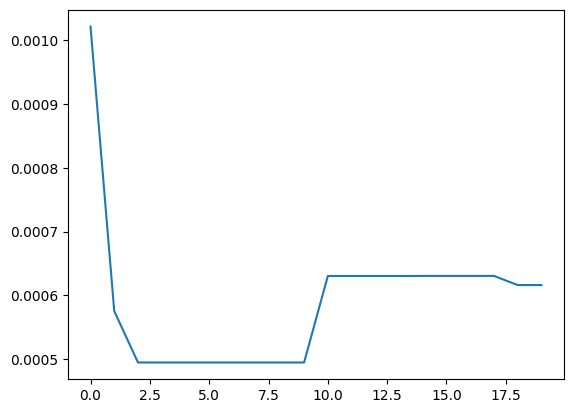

In [4]:
plt.plot(pred_losses)

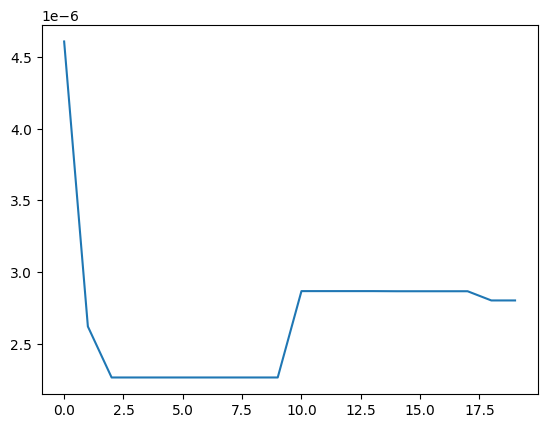

In [5]:
plt.plot(recon_losses)

In [6]:
# function to output the state space dynamics of the orbit
def orbitdyn2D(t,x,mu):
    # mu = 398571 # [km^3*s^-2]
    r = LA.norm([x[0][0], x[0][1]]) # magnitude of position vector
    ax = -mu*x[0][0]/r**3 # acceleration in x-dir based on two-body problem
    ay = -mu*x[0][1]/r**3 # acceleration in y-dir based on two-body problem

    fdyn = np.array([x[0][2], x[0][3], ax, ay])
    return fdyn


# runge-kutta fourth-order numerical integration
def rk4(func, tk, _yk, uk, _dt, **kwargs):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk,uk, **kwargs)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)),uk, **kwargs)
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)),uk, **kwargs)
    f4 = func(tk + _dt, _yk + (f3 * _dt),uk, **kwargs)

    # return an average of the derivative over tk, tk + dt
    return np.array(_yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4))

# ***Full Orbit Prediction w/ multiple altitudes***

c:\Users\georg\Documents\University\FIT\Research\KAN Network\TwoBodyProblem\.venv\Lib\site-packages\kan\KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


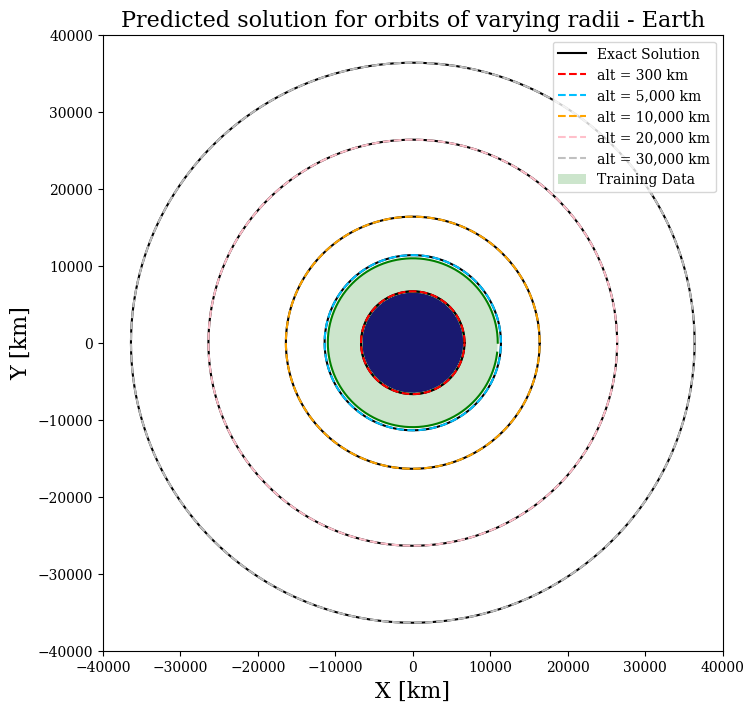

Text(0.5, 0.98, 'Error in Position States - Earth')

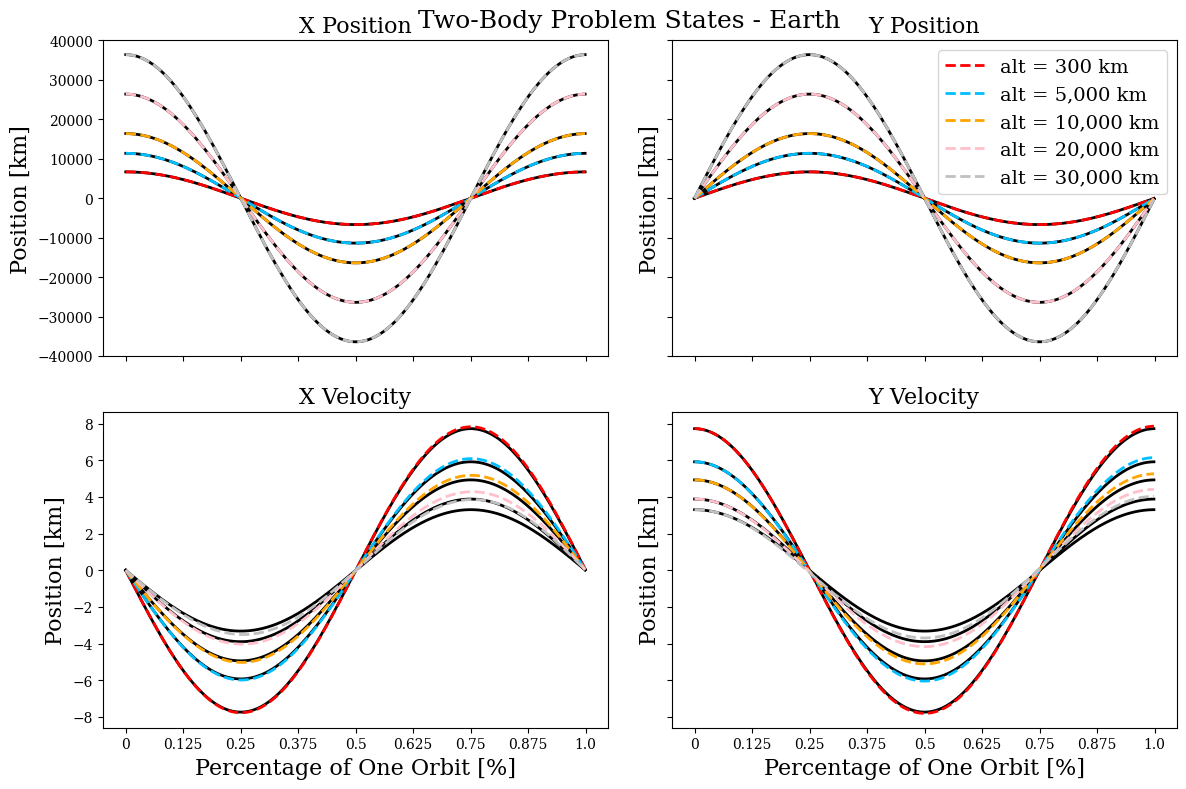

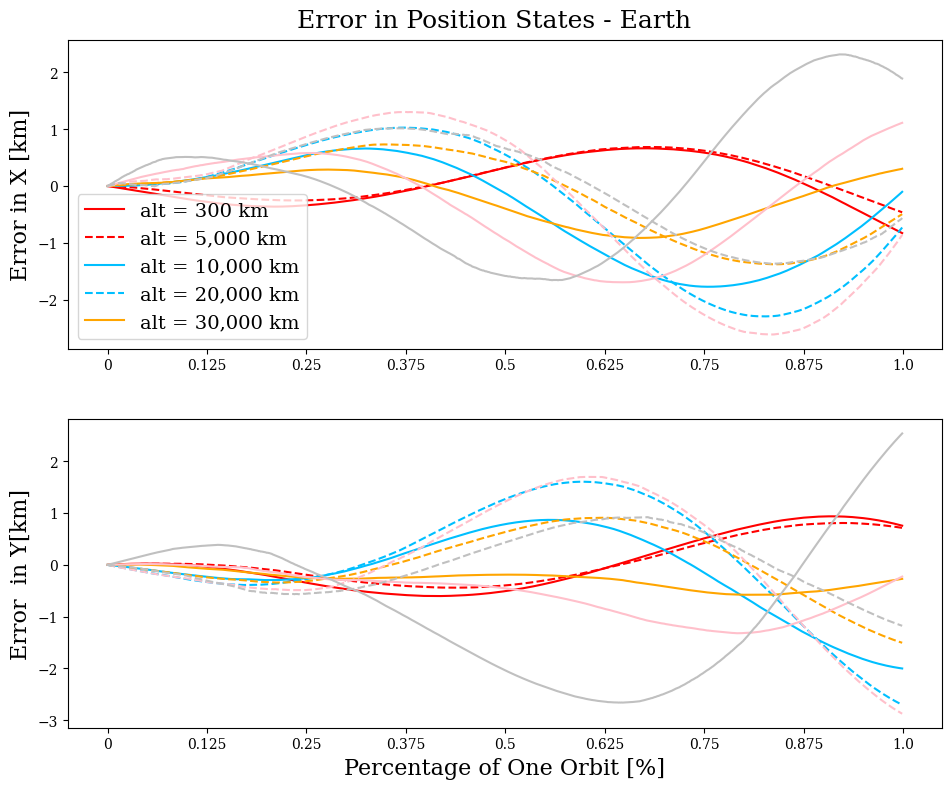

In [11]:
# Two Body Problem parameters
G = 6.6742e-20 # Gravitational constant [m^3*kg^-1*s^-2]
r_Earth = 6378.14  # Average radius of Earth [km]
m1 = 5.974e24 # mass of Earth [kg]
m2 = 1000 # mass of satellite [kg]
mu_Earth = G*(m1 + m2) # gravitational parameter [km^3*s^-2]
# mu = 398571
alt = [300, 5000, 10000, 20000, 30000]
dp = 800

pred = torch.zeros((0, dp, nx))
exact = torch.zeros((0, dp, nx))

# Orbital Dynamics 
for j in range(len(alt)):
    ra = r_Earth + alt[j] # radius of Perigee [km]
    rp = (ra -e*ra)/(1+e)
    a = (rp + ra)/2 # Semi-Major axis [km]
    period = int(2*np.pi*(a**3/mu_Earth)**0.5) # Period of Orbit

    # initial condition (start at periapsis)
    x = rp
    y = 0
    x_dot = 0
    y_dot = (mu_Earth*((2/rp) - (1/a)))**0.5

    dt = (period)/(dp)
    x0_2D = torch.tensor([[x, y, x_dot, y_dot]]) # [1x4]
    time = np.linspace(0, period, dp) # simulate for dp=1000 data points
    xk = torch.clone(x0_2D)

    sol = np.empty([nx,])
    i = 0

    initial_phi_without_states = model(x0_2D) # [1x6]
    initial_phi = torch.cat((x0_2D,initial_phi_without_states),1) # [1x10]

    # ~~~~~~ Creating tensors to store system states ~~~~~~~ #
    new_states = torch.zeros(nx,dp)
    next_state = torch.transpose(x0_2D,0,1)
    phihat_i_im1 = torch.transpose(initial_phi,0,1) # [10x1]

# ~~~~~~ System Evolution ~~~~~~~ #
    for t in time:

        # ~~~~~~~~~ Straight Koopman Prediction ~~~~~~~~~ #
        new_states[:,i] = next_state[:,0] # saving states
        phihat_ip1_i = torch.matmul(K.cpu(), phihat_i_im1) # [10x1]

        # ~~~~~~~~~~ Relifting of States ~~~~~~~~~~ #
        next_state = torch.matmul(P.cpu(),phihat_ip1_i) # extracting the next state # [4x1]
        next_state_encoded = torch.transpose(model(torch.transpose(next_state,0,1)),0,1) # stacking original states on # [6x1]
        phihat_i_im1 = torch.cat((next_state,next_state_encoded),0) # [10x1]
        
        # ~~~~~~~ Exact Nonlinear Dynamics ~~~~~~~~ #
        sol = np.vstack((sol, xk))
        xk = rk4(orbitdyn2D, t, xk, mu_Earth, dt) # RK4 approximation of solution
        i = i+1

    sol = torch.FloatTensor(sol[1:,:])
    new_states = torch.transpose(new_states,0,1)

    pred = torch.vstack([pred, new_states[None,:]])  
    exact = torch.vstack([exact, sol[None,:]])  
pred = pred.detach().numpy()
exact = exact.detach().numpy()

# ~~~~~~~~~~~~~~~~~~~~ Plotting the orbits ~~~~~~~~~~~~~~~~~~~~~~#
training_lim = torch.load("Training_Plot.pt")
# Setting up Spherical Earth to Plot
N = 50
phi = np.linspace(0, 2 * np.pi, N)
theta = np.linspace(0, np.pi, N)
theta, phi = np.meshgrid(theta, phi)
X_Earth = r_Earth * np.cos(phi) * np.sin(theta)
Y_Earth = r_Earth * np.sin(phi) * np.sin(theta)

# Plotting Earth and Orbit
mpl.rc('font',family='Serif')
fig = plt.figure(figsize = (8,8))
ax = plt.axes()
ax.plot(training_lim[:,0,0], training_lim[:,1,0], 'green')
ax.plot(training_lim[:,0,1], training_lim[:,1,1], 'green')
f1, = ax.fill(training_lim[:,0,1], training_lim[:,1,1], alpha=0.2, facecolor='green')
ax.fill(training_lim[:,0,0], training_lim[:,1,0],facecolor='white')
ax.fill(X_Earth, Y_Earth, color='midnightblue')
plt.title('Two-Body Orbit')
ax.set_xlabel('X [km]', fontsize = 16)
ax.set_ylabel('Y [km]', fontsize = 16)

colours = ['black', 'red','deepskyblue', 'orange', 'pink', 'silver']
line = ['-', '--',':']
titles = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
handle_exp = ['R = 300 km', 'R = 5,000 km','R = 10,000 km', 'R = 20,000 km', 'R = 30,000 km']

p1, = ax.plot(exact[0,:,0], exact[0,:,1], 'black')
p2, = ax.plot(pred[0,:,0], pred[0,:,1], linestyle='--', color=colours[1])
ax.plot(exact[1,:,0], exact[1,:,1], 'black')
p3, = ax.plot(pred[1,:,0], pred[1,:,1], linestyle='--', color=colours[2])
ax.plot(exact[2,:,0], exact[2,:,1], 'black')
p4, = ax.plot(pred[2,:,0], pred[2,:,1], linestyle='--', color=colours[3])
ax.plot(exact[3,:,0], exact[3,:,1], 'black')
p5, = ax.plot(pred[3,:,0], pred[3,:,1], linestyle='--', color=colours[4])
ax.plot(exact[4,:,0], exact[4,:,1], 'black')
p6, = ax.plot(pred[4,:,0], pred[4,:,1], linestyle='--', color=colours[5])

ax.legend(handles = [p1, p2, p3, p4, p5, p6, f1], labels=['Exact Solution','alt = 300 km', 'alt = 5,000 km','alt = 10,000 km', 'alt = 20,000 km', 'alt = 30,000 km', 'Training Data'])
ax.set_title('Predicted solution for orbits of varying radii - Earth', fontsize = 16)

# Make axes limits
xylim = np.array([ax.get_xlim(), ax.get_ylim()]).T
XYlim = np.asarray([min(xylim[0]), max(xylim[1])])
ax.set_xlim(XYlim)
ax.set_ylim(XYlim)
plt.show()

# ~~~~~~~~~~~~~~~~~~~ Plotting the States ~~~~~~~~~~~~~~~~~~~~~ #
fig2, ax2 = plt.subplots(2, 2, sharex = 'col', sharey = 'row', figsize = (12, 8))
fig2.tight_layout(pad = 3.0)

for j in range(len(alt)):
    for i in range(4):
        if i == 0:
            a = 0
            b = 0
        elif i == 1:
            a = 0
            b = 1
        elif i == 2:
            a = 1
            b = 0
        elif i == 3:
            a = 1
            b = 1
        p9, = ax2[a,b].plot(exact[j,:,i], color=colours[0], linestyle=line[0], label='_nolegend_', linewidth=2)

for j in range(len(alt)):
    for i in range(4):
        if i == 0:
            a = 0
            b = 0
        elif i == 1:
            a = 0
            b = 1
        elif i == 2:
            a = 1
            b = 0
        elif i == 3:
            a = 1
            b = 1
        p8, = ax2[a,b].plot( pred[j,:,i], color=colours[j+1], linestyle=line[1], label=handle_exp[j], linewidth=2)
        ax2[a,b].set_title(titles[i], fontsize = 16)
        ax2[a,b].set_ylabel('Position [km]', fontsize = 16)
ax2[0,1].legend(labels=['alt = 300 km', 'alt = 5,000 km','alt = 10,000 km', 'alt = 20,000 km', 'alt = 30,000 km', 'Exact Solution'],fontsize=14)
ax2[1,0].set_xlabel("Percentage of One Orbit [%]", fontsize = 16)
ax2[1,1].set_xlabel("Percentage of One Orbit [%]", fontsize = 16)
ax2[1,0].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800],[0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.75, 0.875, 1.00])
ax2[1,1].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800],[0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.75, 0.875, 1.00])
fig2.suptitle('Two-Body Problem States - Earth', fontsize = 18)

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
errorX = (exact[:,:,0] - pred[:,:,0])
errorY = (exact[:,:,1] - pred[:,:,1])

# Setting up Error plot
fig3, ax3 = plt.subplots(2,1, sharey = 'row', figsize = (10,8))
fig3.tight_layout(pad = 3.0)
for j in range(len(alt)):
    ax3[0].plot( errorX[j,:], color=colours[j+1], label=handle_exp[j])
    ax3[1].plot( errorY[j,:], color=colours[j+1], label = handle_exp[j])
    ax3[0].set_ylabel('Error in X [km]', fontsize = 16)
    ax3[1].set_ylabel('Error  in Y[km]', fontsize = 16)
    ax3[1].set_xlabel('Percentage of One Orbit [%]', fontsize = 16)
ax3[0].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800],[0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.75, 0.875, 1.00])
ax3[1].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800],[0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.75, 0.875, 1.00])
ax3[0].legend(labels=['alt = 300 km', 'alt = 5,000 km','alt = 10,000 km', 'alt = 20,000 km', 'alt = 30,000 km', ],fontsize=14)
fig3.suptitle('Error in Position States - Earth', fontsize = 18)

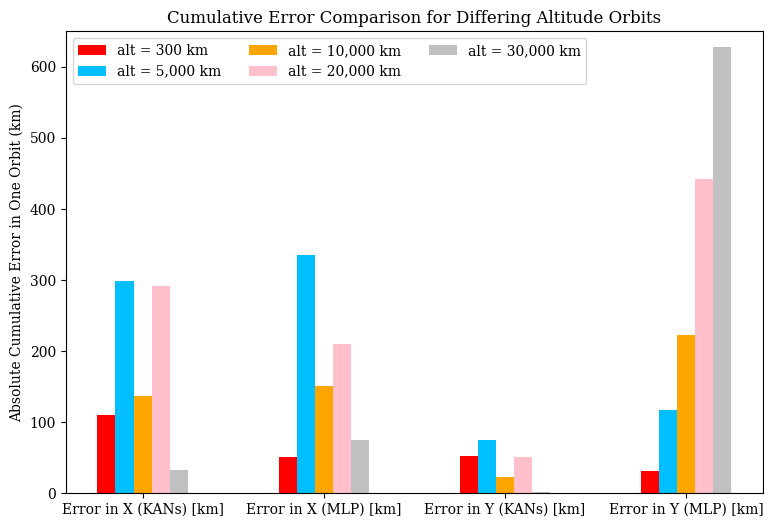

In [36]:
States = ('Error in X (KANs) [km]','Error in X (MLP) [km]', 'Error in Y (KANs) [km]','Error in Y (MLP) [km]')
error_means = {
    'alt = 300 km': (np.abs(np.sum(errorXMLP[0,:])), np.abs(np.sum(errorX[0,:])), np.abs(np.sum(errorYMLP[0,:])), np.abs(np.sum(errorY[0,:]))),
    'alt = 5,000 km': (np.abs(np.sum(errorXMLP[1,:])), np.abs(np.sum(errorX[1,:])), np.abs(np.sum(errorYMLP[1,:])), np.abs(np.sum(errorY[1,:]))),
    'alt = 10,000 km': (np.abs(np.sum(errorXMLP[2,:])), np.abs(np.sum(errorX[2,:])), np.abs(np.sum(errorYMLP[2,:])), np.abs(np.sum(errorY[2,:]))),
    'alt = 20,000 km': (np.abs(np.sum(errorXMLP[3,:])), np.abs(np.sum(errorX[3,:])), np.abs(np.sum(errorYMLP[3,:])), np.abs(np.sum(errorY[3,:]))),
    'alt = 30,000 km': (np.abs(np.sum(errorXMLP[4,:])), np.abs(np.sum(errorX[4,:])), np.abs(np.sum(errorYMLP[4,:])), np.abs(np.sum(errorY[4,:]))),
}

x = np.arange(len(States))  # the label locations
width = 0.1  # the width of the bars
multiplier = -1

fig, ax = plt.subplots(figsize = (9,6))

for attribute, measurement in error_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = colours[multiplier+2])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Absolute Cumulative Error in One Orbit (km)')
ax.set_title('Cumulative Error Comparison for Differing Altitude Orbits')
ax.set_xticks(x+width, States)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 650)

plt.show()

Network Parameters

In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

102